In [3]:
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Here I do my first analysis of quarterly data. I use similar preprocessing found in LR Playground

In [4]:
## Paths for data
quarter_loc = '../data_files/quarterly_data/quarters.csv'
rates_loc = '../data_files/PRIME.csv'
sector_loc = '../data_files/sectors.csv'
redundant_loc = '../data_files/redundant.json'

## Load to dataframes
sectors = pd.read_csv(sector_loc)
quarters = pd.read_csv(quarter_loc)
quarters['Start'] = pd.to_datetime(quarters['Start'])
quarters['End'] = pd.to_datetime(quarters['End'])
rates = pd.read_csv(rates_loc)
rates['DATE'] = pd.to_datetime(rates['DATE'])

## Identify the first date in the datat
min_date = max(quarters['Start'].min(), rates['DATE'].min())

In [5]:
sectors['industry'].value_counts()

Utilities—Regulated Electric      20
Specialty Industrial Machinery    19
Banks—Regional                    15
Semiconductors                    14
Diagnostics & Research            12
                                  ..
Insurance—Specialty                1
Security & Protection Services     1
Health Information Services        1
Real Estate Services               1
Pharmaceutical Retailers           1
Name: industry, Length: 114, dtype: int64

In [6]:
## Create the dates for which the algorithm should make predictions
to_predict = {
    'Q1': '03-31',
    'Q2': '06-30',
    'Q3': '09-30',
    'FY': '12-31'
}

quarters['P_Date'] = quarters['Quarter'].map(to_predict)
quarters['P_Date'] = quarters.apply(lambda x: str(int(x['Year'])) + '-' + x['P_Date'], axis=1)
quarters['P_Date'] = pd.to_datetime(quarters['P_Date'], errors='coerce')
quarters = quarters.dropna()

In [7]:
## Read in stock data to use as target variable
stocks = []
for i, path in enumerate(glob.glob('../data_files/stock_data/*.csv')):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    small_df = df.loc[df['Date'] > min_date].copy()
    small_df['Company'] = re.search(r'(\w+)\.csv', path).groups()[0]
    stocks.append(small_df)
stock_df = pd.concat(stocks)

In [8]:
## Join stock data
closes = stock_df.groupby(['Company', 'Date'])['Close'].first().reset_index()
quarter_df = pd.merge(quarters, closes, left_on=['Company', 'P_Date'], right_on=['Company', 'Date'], how='inner')

## Join interest data
c_rates = rates.set_index('DATE').reindex(quarter_df.set_index('End').index, method='pad').reset_index().drop_duplicates()
quarter_df = pd.merge(quarter_df, c_rates, on='End', how='inner')

In [9]:

## Creates the examples that a model can be trained on.
## The start date is used to create an index which can be later used for 
## backtesting and ensuring completeness of training data
def create_examples(quarter_df, start_year, end_year, n_quarters):
    quarter_map = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'FY': 4}
    quarter_df = quarter_df.loc[quarter_df['Year'] <= end_year].copy()
    quarter_df['q_num'] = quarter_df['Quarter'].map(quarter_map)
    quarter_df['q_index'] = (4 * (quarter_df['Year'] - start_year) + quarter_df['q_num']).astype(int)
    quarter_df = quarter_df.groupby(['Company', 'q_index']).first().reset_index()

    
    results = []
    for i in range(quarter_df['q_index'].max() - n_quarters):
        valid_comp = quarter_df.loc[(quarter_df['q_index'] >= i) & (quarter_df['q_index'] <= i + n_quarters)]
        counts = valid_comp['Company'].value_counts()
        use_companies = counts[counts == n_quarters + 1].index.values
        if len(use_companies) == 0:
            continue
        comp_data = valid_comp.loc[valid_comp['Company'].isin(use_companies)].set_index('Company')
        ind_ex = []
        for j in range(i, i + n_quarters):
            cur_df = comp_data.loc[comp_data['q_index'] == j]
            cur_df.columns = [c + '_' + str(j - i) for c in cur_df.columns]
            ind_ex.append(cur_df)
            vc = cur_df.reset_index()['Company'].value_counts()

            
        ind_ex.append(comp_data.loc[comp_data['q_index'] == i + n_quarters, 'Close'].to_frame())
        result = pd.concat(ind_ex, axis=1).reset_index()
        result['start_week'] = i
        results.append(result)
    
    ret_df = pd.concat(results)
    ret_df['Target'] = ret_df['Close'] / ret_df['Close_' + str(n_quarters - 1)]
    ret_df = ret_df.drop(columns=['Close'], axis=1)
    return ret_df


In [10]:
## Drops all columns from the given dataframe where any of hte
## given values to drop is a prefix of the column name
def drop_columns(df, to_drop):
    drop_these = []
    for c in df.columns:
        for t in to_drop:
            if c.startswith(t):
                drop_these.append(c)
    return df.drop(columns=drop_these, axis=1)
                

In [11]:
## Create the examples
examples = create_examples(quarter_df, 2010, 2015, 4)
examples_df = pd.merge(examples, sectors, left_on='Company', right_on='company')
example_industry = pd.get_dummies(examples_df['industry'])
example_sector = pd.get_dummies(examples_df['sector'])
examples_df = pd.concat((examples_df, example_sector), axis=1)

to_drop = [
    'company', 
    'TimeFrame',
    'Quarter',
    'Year',
    'Date',
    'Start',
    'End',
    'q_index',
    'q_num',
    'P_Date',
    'industry',
    'sector'
]
examples_df = drop_columns(examples_df, to_drop)

In [18]:
for c in examples_df.columns:
    print(c)

Company
income_loss_from_continuing_operations_before_tax_0
income_loss_from_continuing_operations_after_tax_0
other_comprehensive_income_loss_0
net_income_loss_attributable_to_noncontrolling_interest_0
net_income_loss_attributable_to_parent_0
net_income_loss_0
net_income_loss_available_to_common_stockholders_basic_0
participating_securities_distributed_and_undistributed_earnings_loss_basic_0
preferred_stock_dividends_and_other_adjustments_0
costs_and_expenses_0
revenues_0
benefits_costs_expenses_0
comprehensive_income_loss_attributable_to_noncontrolling_interest_0
comprehensive_income_loss_attributable_to_parent_0
comprehensive_income_loss_0
income_tax_expense_benefit_0
operating_expenses_0
operating_income_loss_0
liabilities_0
current_liabilities_0
noncurrent_liabilities_0
assets_0
liabilities_and_equity_0
current_assets_0
noncurrent_assets_0
equity_attributable_to_noncontrolling_interest_0
equity_0
equity_attributable_to_parent_0
Close_0
PRIME_0
income_loss_from_continuing_operation

### Analyze Heavily Correlated Variables
- We want to know which variables we should remove

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


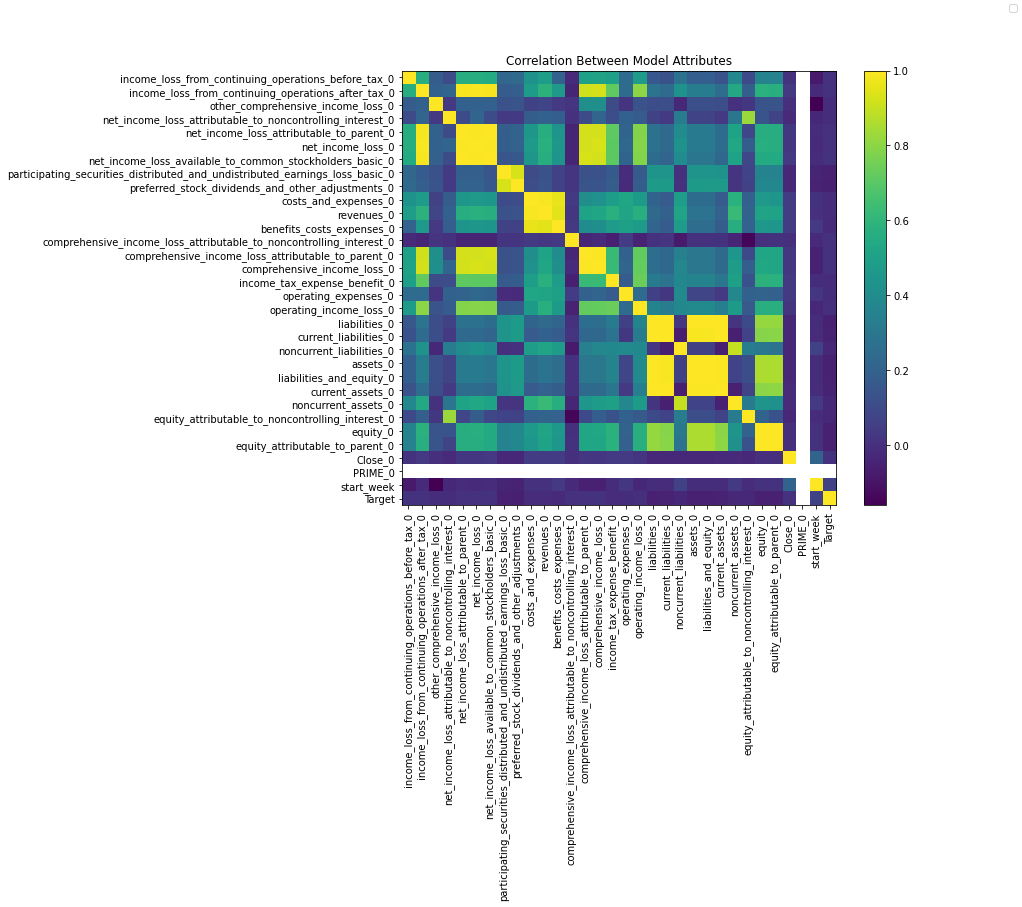

In [12]:
for_corr = create_examples(quarter_df, 2010, 2015, 1)
for_corr = drop_columns(for_corr, to_drop).drop(columns=['Company'], axis=1)

fig, ax = plt.subplots()
corr_df = for_corr.corr()
cbar = ax.imshow(corr_df)
ax.set_xticks(np.arange(corr_df.shape[0]))
ax.set_yticks(np.arange(corr_df.shape[0]))
ax.set_xticklabels(for_corr.columns, rotation=90)
ax.set_yticklabels(for_corr.columns)
ax.set_title('Correlation Between Model Attributes')
fig.set_size_inches(10, 8)
fig.legend()
fig.colorbar(cbar, ax=ax)

In [13]:
## Find heavily correlated variables
## Easier to only look at one quarter
cols = for_corr.columns
cor2high = {}
cor_cutoff = 0.97
for i in range(for_corr.shape[1]):
    for j in range(i + 1, for_corr.shape[1]):
        corr = for_corr[cols[i]].corr(for_corr[cols[j]])
        if corr > cor_cutoff:
            one_clean = cols[i].split('_')
            two_clean = cols[j].split('_')
            one = '_'.join(one_clean[:(len(one_clean) - 1)])
            two = '_'.join(two_clean[:(len(two_clean) - 1)])
            if one not in cor2high:
                cor2high[one] = set()
            cor2high[one].add(two)
            if two not in cor2high:
                cor2high[two] = set()
            cor2high[two].add(one)
            
            print('%03.5f' % corr, cols[i], cols[j])

0.98264 income_loss_from_continuing_operations_after_tax_0 net_income_loss_attributable_to_parent_0
0.98966 income_loss_from_continuing_operations_after_tax_0 net_income_loss_0
0.98207 income_loss_from_continuing_operations_after_tax_0 net_income_loss_available_to_common_stockholders_basic_0
0.99350 net_income_loss_attributable_to_parent_0 net_income_loss_0
0.99886 net_income_loss_attributable_to_parent_0 net_income_loss_available_to_common_stockholders_basic_0
0.99233 net_income_loss_0 net_income_loss_available_to_common_stockholders_basic_0
0.99016 costs_and_expenses_0 revenues_0
0.99237 comprehensive_income_loss_attributable_to_parent_0 comprehensive_income_loss_0
0.99627 liabilities_0 current_liabilities_0
0.99718 liabilities_0 assets_0
0.99718 liabilities_0 liabilities_and_equity_0
0.99563 liabilities_0 current_assets_0
0.99026 current_liabilities_0 assets_0
0.99026 current_liabilities_0 liabilities_and_equity_0
0.99924 current_liabilities_0 current_assets_0
1.00000 assets_0 liabi

In [14]:
reg = RandomForestRegressor()
Y = examples_df['Target']
X = examples_df.drop(columns=['Target', 'start_week', 'Company'], axis=1)
reg.fit(X, Y)
order = np.argsort(reg.feature_importances_)
dont_keep = set()
for i, col in enumerate(X.columns[order]):
    clean_col = col.split('_')
    if len(clean_col) > 1:
        clean_col = '_'.join(clean_col[:(len(clean_col) - 1)])
        if clean_col in dont_keep:
            continue
        if clean_col in cor2high:
            dont_keep |= cor2high[clean_col]

print('Not Keeping')
for c in dont_keep:
    print(c)

with open(redundant_loc, 'w') as fout:
    fout.write(json.dumps(list(dont_keep)))


Not Keeping
equity_attributable_to_parent
revenues
comprehensive_income_loss_attributable_to_parent
net_income_loss
current_assets
current_liabilities
income_loss_from_continuing_operations_after_tax
liabilities
net_income_loss_available_to_common_stockholders_basic
assets


## Hyperparemeter tuning the RF with Hyperopt

In [15]:
from hyperopt import hp
from hyperopt import fmin, tpe
from keras import backend as K

ModuleNotFoundError: No module named 'hyperopt'

In [ ]:


## Create the examples
examples = create_examples(quarter_df, 2010, 2015, 4)
examples_df = pd.merge(examples, sectors, left_on='Company', right_on='company')
example_industry = pd.get_dummies(examples_df['industry'])
example_sector = pd.get_dummies(examples_df['sector'])
examples_df = pd.concat((examples_df, example_sector), axis=1)

to_drop = [
    'company', 
    'TimeFrame',
    'Quarter',
    'Year',
    'Date',
    'Start',
    'End',
    'q_index',
    'q_num',
    'P_Date',
    'industry',
    'sector'
]

to_drop.extend(list(dont_keep)) ## Get rid of the variables deemed unnecessary
examples_df = drop_columns(examples_df, to_drop)
y = examples_df['Target']
x = examples_df.drop(columns=['Target', 'start_week', 'Company'], axis=1)
n_folds = 5
fold_bounds = [int(b) for b in np.linspace(0, len(x), n_folds + 1)]
sets = []
for i in range(n_folds):
    x_test = x.iloc[fold_bounds[i]:fold_bounds[i+1]]
    y_test = y.iloc[fold_bounds[i]:fold_bounds[i+1]]
    x_train = x.drop(x.index[fold_bounds[i]:fold_bounds[i+1]])
    y_train = y.drop(y.index[fold_bounds[i]:fold_bounds[i+1]])
    sets.append({'train':(x_train, y_train), 'test':(x_test, y_test)})

space = hp.choice('a', [{
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 50),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 2)
}])

def objective(args):
    n_est = int(args['n_estimators'])
    min_samp = int(args['min_samples_split'])
    print('NE %d\tMSS %d' % (n_est, min_samp))
    model = RandomForestRegressor(n_estimators=n_est, min_samples_split=min_samp)
    
    mses = np.full((len(sets),), 0.0)
    for i, split in enumerate(sets):
        x_train, y_train = split['train']
        x_test, y_test = split['test']
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        mses[i] = ((pred - y_test) ** 2).mean()
    return mses.mean()
    
    
                

In [ ]:
## Running Hyperopt
import datetime
#best = fmin(objective, space, algo=tpe.suggest, max_evals=60)
#min_samples_split=14, n_estimators=250
print((end-start).total_seconds())

In [ ]:
reg = RandomForestRegressor(n_estimators=250, min_samples_split=14)
mses = np.full((len(sets),), 0.0)
hl = np.full((len(sets),), 0.0)
for i, split in enumerate(sets):
    x_train, y_train = split['train']
    x_test, y_test = split['test']
    print('training_len', len(x_train))
    print('testing_len', len(x_test))
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test)
    mses[i] = ((pred - y_test) ** 2).mean()
    hl[i] = (((pred > 1) & (y_test > 1)) | ((pred < 1) & (y_test < 1))).mean()
print('mse', mses.mean())
print('hl', hl.mean())
    

In [ ]:
import os
os.path.split(os.getcwd())

In [ ]:
os.path.split('hello/')